# Predicting RWRA Scores with Remotely Sensed Features

**Author**: Bryce A Young, Research Assistant  
**Institution**: University of Montana, National Center for Landscape Fire Analysis

**Created**: 2025-02-27  
**Modified**: 2025-02-27

### Overview  
In previous notebooks (located in this repository), I prepared data (`data_prep/`), attributed that data to homes and home ignition zones (`ouray_hiz.ipynb`), and performed extensive analysis on features from tax assessor data (`tax_analysis.ipynb`), remotely-sensed data (`hiz_analysis.ipynb`, `wui_analysis.ipynb`), and rapid wildfire risk assessment data (`risk_data_analysis.ipynb`).

In this notebook, I explore different machine learning models for using the features I attributed to homes to predict RWRA scores. 

This notebook is organized by the following workflow:
1. Feature selection
2. Risk score prediction with Random Forest
3. Model validation
4. Explore different features and machine learning models

## Step 1: Feature Selection
---

In [51]:
# setup environment
import os
### Directory ###
# Repository
os.chdir(r'D:/_PROJECTS/P001_OurayParcel/ouray')
# Root workspace
ws = r'D:/_PROJECTS/P001_OurayParcel'

### Data paths ###
# Folder where all the data inputs and outputs will live
data = os.path.join(ws, 'data')
# Scratch folder for intermediate files
scratch = os.path.join(data, '_temp')
# Any final outputs go here
out = os.path.join(data, '_out')
# Figures to export
figs = os.path.join(out, 'figures')

# correct working directory
os.getcwd()

'D:\\_PROJECTS\\P001_OurayParcel\\ouray'

In [114]:
import geopandas as gpd
import pandas as pd

# Read in data
gdf = gpd.read_file(os.path.join(out, 'feat_risk_refact.gpkg'), layer='full')
# Change geodataframe to regular dataframe by dropping geometry column
df = gdf.drop(columns=['geometry'], axis=1)
pd.set_option('display.max_columns', None)
df.head()


,rwra_index,feat_index,parcel_num,Year,address,ParcelNum,Model,Address_Visible,Driveway_Clearance,Driveway_Lenth,Dist_to_Danger_Topo,Slope_Final,Background_Fuels,Defensible_Space,Roofing_Material,Building_Exterior,Other_Combustibles,Decks_and_Fencing,Proximity_to_Neighboring_Home,Ingress_Egress,Score_Final,Risk_Rating,County,wui_class,min_ssd,mean_cc0_2m,mean_cc2_4m,mean_cc4_8m,mean_cc8_40m,intersections,PARCELNB,ACCOUNT,ACRES_calc,hiz_ext_out,Actual Year Built\n(AYB),Air Conditioning\n(AIRC),Architecture Style\n(ARCH),Area Acres\n(Area_ACRES),Area SQFT\n(Area_SQFT),Condition\n(COND),DGR - Detached Garage\n(SubArea_DGR),Effective Year Built\n(EYB),Exterior Percent\n(EXW_PERCENT),Exterior Wall\n(EXW),Floor\n(FLR),Frame\n(FRME),Heating Fuel\n(HTFL),Interior Wall\n(INT),Neighborhood\n(NBHD),OPP - Open Porch\n(SubArea_OPP),PTO - Patio\n(SubArea_PTO),RMS\n(RMS),Roof Cover\n(RCVR),Roof Structure\n(RSTR),Type,WBL - Wood Balcony\n(SubArea_WBL),sum_cc
0,0,2836,430506210001,2013.0,123 EXAMPLE DRIVE,430506210001,A,0,5,NaN,0,NaN,75,75,0,0,10,50,NaN,10,225.0,High,Ouray County,1,31.525324,0.028983,0.080487,0.112609,0.179108,1,430506210001,R003918,49.6527,True,2008.0,1 - NONE,COMMERCIAL,0.0,6991.1,3 - GOOD,0.0,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,5000591 - LHV TR 35+,327.4,0.0,0.776148,METAL,GABLE,Commercial,0.0,0.401187
1,1,1110,430506210001,2013.0,129 EXAMPLE DRIVE,430506210001,A,0,5,NaN,0,NaN,50,50,0,20,10,0,NaN,0,135.0,Low,Ouray County,1,31.525324,0.051442,0.096132,0.093393,0.155315,1,430506210001,R003918,49.6527,False,2008.0,1 - NONE,COMMERCIAL,0.0,6991.1,3 - GOOD,0.0,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,5000591 - LHV TR 35+,327.4,0.0,0.776148,METAL,GABLE,Commercial,0.0,0.396283
2,2,3672,430506210001,2013.0,135 EXAMPLE DRIVE,430506210001,A,0,5,NaN,75,NaN,50,100,0,60,10,50,NaN,10,360.0,Extreme,Ouray County,1,66.164004,0.035089,0.059277,0.031211,0.026098,0,430506210001,R003918,49.6527,True,2008.0,1 - NONE,COMMERCIAL,0.0,6991.1,3 - GOOD,0.0,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,5000591 - LHV TR 35+,327.4,0.0,0.776148,METAL,GABLE,Commercial,0.0,0.151675
3,3,3843,430506210001,2013.0,141 EXAMPLE DRIVE,430506210001,A,0,0,NaN,0,NaN,50,75,200,60,30,0,NaN,0,415.0,Extreme,Ouray County,1,78.033957,0.054498,0.065344,0.076959,0.213781,0,430506210001,R003918,49.6527,False,2008.0,1 - NONE,COMMERCIAL,0.0,6991.1,3 - GOOD,0.0,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,5000591 - LHV TR 35+,327.4,0.0,0.776148,METAL,GABLE,Commercial,0.0,0.410582
4,5,921,403935100181,2017.0,416 COUNTY ROAD 22A,403935100181,B,5,0,11.0,0,0.0,10,50,0,0,0,0,0.0,0,76.0,Low,Ouray County,1,211.505051,0.048738,0.084885,0.034318,0.000000,0,403935100181,R000531,32.7283,False,2012.0,1 - NONE,SINGLE STORY,0.0,4034.9,3 - GOOD,0.0,2015.0,100.0,CONC/MSNRY,WDJST,WOOD,GAS,DRYWALL,7000006 - Outlying6,572.0,215.0,0.776148,ASPHALT,GABLE,Residence,0.0,0.167940


In [115]:
df.columns

Index(['rwra_index', 'feat_index', 'parcel_num', 'Year', 'address',
       'ParcelNum', 'Model', 'Address_Visible', 'Driveway_Clearance',
       'Driveway_Lenth', 'Dist_to_Danger_Topo', 'Slope_Final',
       'Background_Fuels', 'Defensible_Space', 'Roofing_Material',
       'Building_Exterior', 'Other_Combustibles', 'Decks_and_Fencing',
       'Proximity_to_Neighboring_Home', 'Ingress_Egress', 'Score_Final',
       'Risk_Rating', 'County', 'wui_class', 'min_ssd', 'mean_cc0_2m',
       'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m', 'intersections',
       'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'Actual Year Built\n(AYB)', 'Air Conditioning\n(AIRC)',
       'Architecture Style\n(ARCH)', 'Area Acres\n(Area_ACRES)',
       'Area SQFT\n(Area_SQFT)', 'Condition\n(COND)',
       'DGR - Detached Garage\n(SubArea_DGR)', 'Effective Year Built\n(EYB)',
       'Exterior Percent\n(EXW_PERCENT)', 'Exterior Wall\n(EXW)',
       'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)'

In [116]:
df = df.drop(columns=['Neighborhood\n(NBHD)', 'Area Acres\n(Area_ACRES)', 'Actual Year Built\n(AYB)'])

So WBL, DGR, OPP, and PTO have mostly 0 values, which I explored in `tax_analysis.ipynb`. So as numeric columns they are not very useful since the data is so skewed. Instead of log-transforming the data, I'm going to change it to categorical data. Below, I print the range of values for each column so we cal choose how to classify the values.

In [117]:
# List of target columns
cols = ['WBL - Wood Balcony\n(SubArea_WBL)', 
        'DGR - Detached Garage\n(SubArea_DGR)', 
        'PTO - Patio\n(SubArea_PTO)',
        'OPP - Open Porch\n(SubArea_OPP)']

# Print basic statistics
for col in cols:
    print(f"--- {col} ---")
    print("Min:", df[col].min())
    print("Max:", df[col].max())
    print("Unique values:", df[col].nunique())
    print("Value counts:\n", df[col].value_counts().head(10))  # Print top 10 most frequent values
    print("\n")

--- WBL - Wood Balcony
(SubArea_WBL) ---
Min: 0.0
Max: 1460.5
Unique values: 199
Value counts:
 WBL - Wood Balcony\n(SubArea_WBL)
0.0      1057
80.0       10
60.0       10
72.0       10
48.0       10
32.0        9
40.0        8
96.0        6
200.0       6
360.0       6
Name: count, dtype: int64


--- DGR - Detached Garage
(SubArea_DGR) ---
Min: 0.0
Max: 2000.0
Unique values: 79
Value counts:
 DGR - Detached Garage\n(SubArea_DGR)
0.0       1265
576.0       13
720.0       10
624.0        6
768.0        5
672.0        5
1200.0       3
660.0        3
480.0        3
960.0        3
Name: count, dtype: int64


--- PTO - Patio
(SubArea_PTO) ---
Min: 0.0
Max: 5432.4
Unique values: 269
Value counts:
 PTO - Patio\n(SubArea_PTO)
0.0       1075
288.0        5
144.0        5
1870.5       5
160.0        4
336.0        3
270.0        3
192.0        3
364.0        3
360.0        3
Name: count, dtype: int64


--- OPP - Open Porch
(SubArea_OPP) ---
Min: 0.0
Max: 1937.9
Unique values: 568
Value counts:
 O

In [118]:
# Define categorization function
def categorize_feature(value, small_threshold, large_threshold):
    if value == 0:
        return "None"
    elif value <= small_threshold:
        return "Small"
    else:
        return "Large"

# Apply categorization rules to df
df['Size_WBL'] = df['WBL - Wood Balcony\n(SubArea_WBL)'].apply(lambda x: categorize_feature(x, 100, 100))
df['Size_DGR'] = df['DGR - Detached Garage\n(SubArea_DGR)'].apply(lambda x: categorize_feature(x, 600, 600))
df['Size_PTO'] = df['PTO - Patio\n(SubArea_PTO)'].apply(lambda x: categorize_feature(x, 100, 100))
df['Size_OPP'] = df['OPP - Open Porch\n(SubArea_OPP)'].apply(lambda x: categorize_feature(x, 100, 100))

# Drop original numeric columns since we now have categorical versions
df = df.drop(columns=['WBL - Wood Balcony\n(SubArea_WBL)', 
                      'DGR - Detached Garage\n(SubArea_DGR)', 
                      'PTO - Patio\n(SubArea_PTO)',
                      'OPP - Open Porch\n(SubArea_OPP)'])

# Confirm changes
df[['Size_WBL', 'Size_DGR', 'Size_PTO', 'Size_OPP']].head()


,Size_WBL,Size_DGR,Size_PTO,Size_OPP
0,None,None,None,Large
1,None,None,None,Large
2,None,None,None,Large
3,None,None,None,Large
4,None,None,Large,Large


In [119]:
# Create prediction dataframe 1 - numeric - min cols
pred1 = df[
    [
    'Score_Final',
    'min_ssd', 
    'intersections', 
    'sum_cc', 
    'ACRES_calc', 
    'Area SQFT\n(Area_SQFT)',
    'Effective Year Built\n(EYB)',
    'RMS\n(RMS)'
    ]
]

# prediction df 2 - numeric - added different canopy closure classes instead of sum_cc
pred2 = df[
    [
    'Score_Final',
    'min_ssd', 
    'intersections', 
    'mean_cc0_2m',
    'mean_cc2_4m', 
    'mean_cc4_8m', 
    'mean_cc8_40m', 
    'ACRES_calc', 
    'Area SQFT\n(Area_SQFT)',
    'Effective Year Built\n(EYB)',
    'RMS\n(RMS)'
    ]
]

# prediction df 3 - mix of numeric and categorical data from tax assessor only
pred3 =  df[
    [
    'Risk_Rating',
    'Air Conditioning\n(AIRC)',
    'Architecture Style\n(ARCH)',
    'Area SQFT\n(Area_SQFT)', 'Condition\n(COND)',
    'Size_DGR', 'Effective Year Built\n(EYB)',
    'Exterior Percent\n(EXW_PERCENT)', 'Exterior Wall\n(EXW)',
    'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)',
    'Interior Wall\n(INT)',
    'Size_OPP', 'Size_PTO',
    'RMS\n(RMS)', 'Roof Cover\n(RCVR)', 'Roof Structure\n(RSTR)', 'Type',
    'Size_WBL'
    ]
]

# prediciton df 4 - my favorite columns (mixed numeric and categorical data)
pred4 = df[
    [
    'Risk_Rating',
    'wui_class',
    'hiz_ext_out',
    'min_ssd', 
    'intersections', 
    'sum_cc', 
    'ACRES_calc', 
    'Area SQFT\n(Area_SQFT)',
    'Effective Year Built\n(EYB)',
    'RMS\n(RMS)',
    'Architecture Style\n(ARCH)',
    'Condition\n(COND)',
    'Exterior Wall\n(EXW)',
    'Heating Fuel\n(HTFL)',
    'Roof Cover\n(RCVR)', 
    'Roof Structure\n(RSTR)',
    'Size_OPP',
    'Size_DGR',
    'Size_WBL',
    'Size_PTO'
    ]
]

# prediction df 5 - all columns
pred5 = df[
    [
    'Risk_Rating',
       'wui_class', 'min_ssd', 'mean_cc0_2m',
       'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m', 'intersections',
       'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'Air Conditioning\n(AIRC)',
       'Architecture Style\n(ARCH)',
       'Area SQFT\n(Area_SQFT)', 'Condition\n(COND)',
       'Size_DGR', 'Effective Year Built\n(EYB)',
       'Exterior Percent\n(EXW_PERCENT)', 'Exterior Wall\n(EXW)',
       'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)',
       'Interior Wall\n(INT)',
       'Size_OPP', 'Size_PTO',
       'RMS\n(RMS)', 'Roof Cover\n(RCVR)', 'Roof Structure\n(RSTR)', 'Type',
       'Size_WBL', 'sum_cc'
    ]
]

We're going to determine feature importance with a random forest. First, let's split the data into training and testing. 

In [120]:
from sklearn.model_selection import train_test_split

# Define train-test split function
def split_data(df):
    X = df.drop(columns=['Score_Final'])
    y = df['Score_Final']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Apply to numeric datasets
X_train1, X_test1, y_train1, y_test1 = split_data(pred1)
X_train2, X_test2, y_train2, y_test2 = split_data(pred2)

# Define train-test split function
def split_data(df):
    X = df.drop(columns=['Risk_Rating'])
    y = df['Risk_Rating']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Apply to categorical data
X_train3, X_test3, y_train3, y_test3 = split_data(pred3)
X_train4, X_test4, y_train4, y_test4 = split_data(pred4)
X_train5, X_test5, y_train5, y_test5 = split_data(pred5)


## Step 2: Random Forest Regressor
---

In [83]:
## PRED 1 ##

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Train Random Forest on pred1 (repeat for pred2)
rf = RandomForestRegressor(n_estimators=200, 
                           max_depth=20,
                           max_features='sqrt',
                           min_samples_split=5,
                           min_samples_leaf=4,
                           random_state=42)
rf.fit(X_train1, y_train1)

# Get feature importance
importances = pd.DataFrame({'Feature': X_train1.columns, 'Importance': rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)

# Display results
importances

,Feature,Importance
3,ACRES_calc,0.289350
0,min_ssd,0.201417
4,Area SQFT\n(Area_SQFT),0.200856
2,sum_cc,0.193394
5,Effective Year Built\n(EYB),0.061016
6,RMS\n(RMS),0.029845
1,intersections,0.024122


In [84]:
## PRED 2 ## 

rf2 = RandomForestRegressor(n_estimators=200, 
                           max_depth=20,
                           max_features='sqrt',
                           min_samples_split=5,
                           min_samples_leaf=4,
                           random_state=42)
rf2.fit(X_train2, y_train2)

importances2 = pd.DataFrame({'Feature': X_train2.columns, 'Importance': rf2.feature_importances_})
importances2 = importances2.sort_values(by='Importance', ascending=False)

importances2

,Feature,Importance
6,ACRES_calc,0.223377
0,min_ssd,0.143456
2,mean_cc0_2m,0.133419
7,Area SQFT\n(Area_SQFT),0.129968
4,mean_cc4_8m,0.105165
3,mean_cc2_4m,0.097430
5,mean_cc8_40m,0.095587
8,Effective Year Built\n(EYB),0.038670
1,intersections,0.016961
9,RMS\n(RMS),0.015967


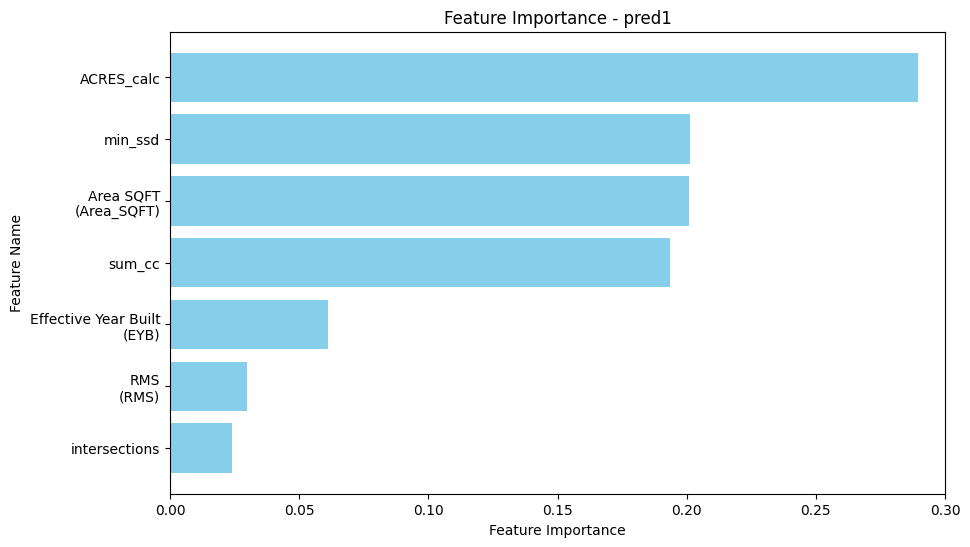

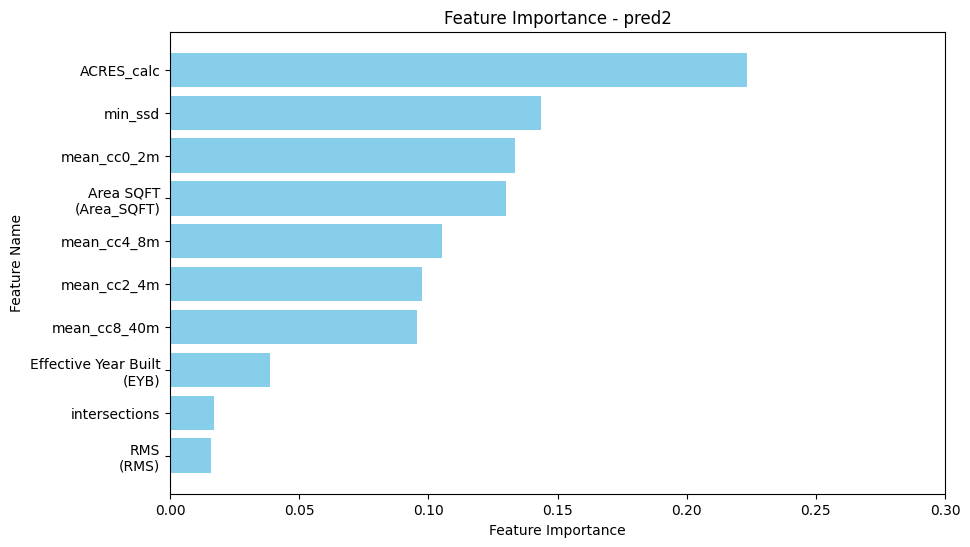

In [85]:
import matplotlib.pyplot as plt

# Function to plot feature importance
def plot_feature_importance(importances, title):
    plt.figure(figsize=(10, 6))
    plt.barh(importances['Feature'], importances['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title(title)
    plt.xlim(0, 0.3)
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

# Plot feature importance for pred1
plot_feature_importance(importances, "Feature Importance - pred1")

# Plot feature importance for pred2
plot_feature_importance(importances2, "Feature Importance - pred2")

I'm dissapointed to see that the largest predictor of risk score is the property acreage. It's good to know, but I don't think this model is going to work very well :(

Let's evaluate how each model is performing here.

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate RF model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, dataset_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        "Dataset": dataset_name,
        "Train R²": r2_score(y_train, y_train_pred),
        "Test R²": r2_score(y_test, y_test_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
    }
    
    return metrics

# Evaluate models for pred1 and pred2
results = []
results.append(evaluate_model(rf, X_train1, X_test1, y_train1, y_test1, "pred1"))
results.append(evaluate_model(rf2, X_train2, X_test2, y_train2, y_test2, "pred2"))

import pandas as pd
results_df = pd.DataFrame(results)

results_df

,Dataset,Train R²,Test R²,Test MAE,Test MSE
0,pred1,0.539363,0.176030,106.313839,25108.200126
1,pred2,0.605671,0.208674,102.179268,24113.463702


### Iterative RF results
The model is definitely overfitting - you can see in the difference between train r^2 and test r^2. So what I'm going to do is go back and tune the hyperparameters in the RandomForestRegressor function. Then we'll try again.

#### 1st run
Default parameters for [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), with random_state=42.   
**pred1**  
Train R<sup>2</sup>: 0.881617, Test R<sup>2</sup>: 0.228703  
**pred2**  
Train R<sup>2</sup>: 0.883672, Test R<sup>2</sup>: 0.204017
#### 2nd run  
(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42)  
**pred1**  
Train R<sup>2</sup>: 0.615082, Test R<sup>2</sup>: 0.186226  
**pred2**  
Train R<sup>2</sup>: 0.621201, Test R<sup>2</sup>: 0.189483  
#### 3rd run
(n_estimators=200, max_depth=20, min_samples_split=5, max_features='sqrt', min_samples_leaf=4, random_state=42)  
**pred1**  
Train R<sup>2</sup>: 0.539363, Test R<sup>2</sup>: 0.176030  
**pred2**  
Train R<sup>2</sup>: 0.605671, Test R<sup>2</sup>: 0.208674

With three different model variations, the fit is consistently better on the training data than the testing data. Because of the variable relationships and correlations that we explored in `risk_data_analysis.ipynb`, I am skeptical that we will be able to predict risk scores at all. These three model attempts illustrate the difficulty. In all three models, ACRES_calc was the most important feature by far. Intersections (number of adjacent homes in HIZ) was consistently the least important feature, with an importance of 0.000000 in the 2nd run. In the 3rd run, min_ssd was the second most important feature (importance=0.20 in pred1 and 0.14 in pred2). In the data analysis, I demonstrated that min_ssd had very little correlation with proximity_to_neighboring_home. Therefore, seeing this with the second highest predictive capacity is indicative that the structure risk score is difficult to predict. This is confirmed by Meldrum et al. 2022 who explain that in the East Troublesome fire, structures with the highest risk scores were structures that could not be observed. 

In all 3 models, the three lowest importance were Effective Year Built\n(EYB), Rooms\n(RMS), and intersections. So I would drop these columns if I were to try to make predictions, but I'm not going to go that far here because I don't think that predictions can be made accurately.

The test MAE (mean absolute error) is about 106 poionts for pred1 and 102 points for pred2, which is actually pretty decent. 

## Step 3: Random Forest Classifier
---
Now let's look at the mix of categorical and numeric variables (pred3-5) in predicting risk classes. Before I can use the RandomForestClassifier, I have to do some data transformation of my categorical variables in order to make them numeric. So let's handle that first.

Documentation can be found online for the [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [121]:
# Separate num_cols and cat_cols
cat_cols = X_train3.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train3.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['Air Conditioning\n(AIRC)', 'Architecture Style\n(ARCH)', 'Condition\n(COND)', 'Size_DGR', 'Exterior Wall\n(EXW)', 'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)', 'Interior Wall\n(INT)', 'Size_OPP', 'Size_PTO', 'Roof Cover\n(RCVR)', 'Roof Structure\n(RSTR)', 'Type', 'Size_WBL']
Numeric columns: ['Area SQFT\n(Area_SQFT)', 'Effective Year Built\n(EYB)', 'Exterior Percent\n(EXW_PERCENT)', 'RMS\n(RMS)']


Below I use onehotencoder to one hot encode my categorical variables. This will blow up the size of my dataset. We can see from the printout below that pred3 training and testing datasets now have 138 columns. There could be a lot of noise here, but many columns is not uncommon in machine learning. Let's see how it goes with predictions.

In [122]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Define OneHotEncoder for categorical columns
encoder = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)],
    remainder="passthrough"  # Keeps numeric columns unchanged
)

# Apply encoding to X_train3 & X_test3
X_train3_enc = encoder.fit_transform(X_train3)
X_test3_enc = encoder.transform(X_test3)

# Convert back to DataFrame with proper column names
X_train3_enc = pd.DataFrame(X_train3_enc, columns=encoder.get_feature_names_out())
X_test3_enc = pd.DataFrame(X_test3_enc, columns=encoder.get_feature_names_out())

print("Encoded X_train3 shape:", X_train3_enc.shape)
print("Encoded X_test3 shape:", X_test3_enc.shape)

Encoded X_train3 shape: (1120, 61)
Encoded X_test3 shape: (280, 61)


In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train3_enc, y_train3) # Using one-hot encoded variables

# Make predictions
y_pred3 = clf.predict(X_test3_enc)


In [125]:
# Accuracy Score
accuracy = accuracy_score(y_test3, y_pred3)
print(f"Accuracy: {accuracy:.3f}")

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test3, y_pred3))

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test3, y_pred3, digits=3))


Accuracy: 0.454
Confusion Matrix:
 [[ 7 11  4  1  0]
 [ 1 87 14 18  0]
 [ 0 20 25 13  0]
 [ 1 43 15  7  0]
 [ 1 11  0  0  1]]
Classification Report:
               precision    recall  f1-score   support

     Extreme      0.700     0.304     0.424        23
        High      0.506     0.725     0.596       120
         Low      0.431     0.431     0.431        58
    Moderate      0.179     0.106     0.133        66
   Very High      1.000     0.077     0.143        13

    accuracy                          0.454       280
   macro avg      0.563     0.329     0.345       280
weighted avg      0.452     0.454     0.418       280



The accuracy of the pred3 model was quite low (0.45). This model used only tax assessor data to predict the final risk class (Extreme, Very High, High, Moderate, Low). Let's make a better visualization of the confusion matrix below.

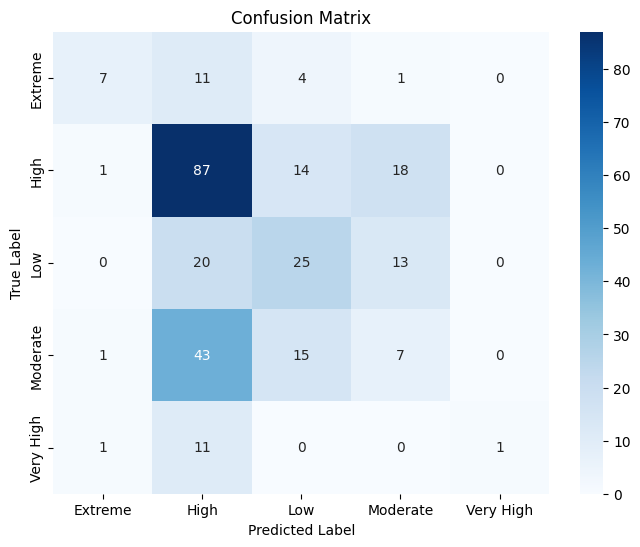

In [130]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test3, y_pred3)
classes = np.unique(y_test3)  # Get class labels

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

It looks like this model predicted most homes to be in the 'High' Risk_Rating class. This is probably because most homes are that class, so that's what the model was trained on best (see distribution of classes in the printout from the below codeblock). 

It also predicted many classes as High that were actually classified as Moderate. This could be partially due to the uneven class breaks of final risk scores. 

In [131]:
print(y_train3.value_counts())

Risk_Rating
High         492
Moderate     247
Low          246
Extreme       94
Very High     41
Name: count, dtype: int64


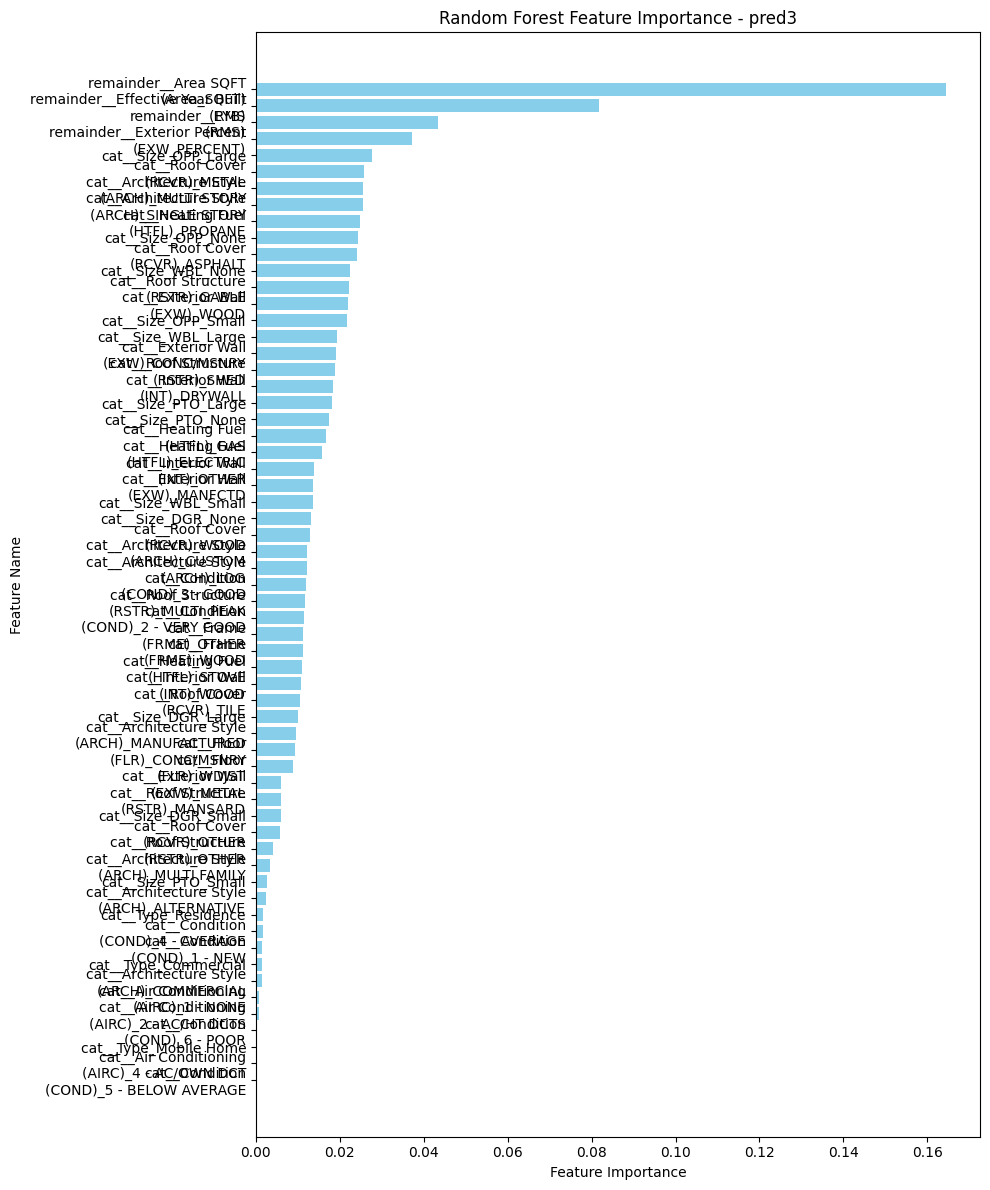

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train3_enc.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, min(12, 0.5 * len(feature_importances))))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Feature Importance - pred3')
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest at top
plt.show()


The most important feature here is Area_SQFT. So the size of the home is the biggest predictor of final risk classification in this model. 

Now let's do the same thing with pred4.

`wui_class` is not an ordinal classification so we will move it to cat_cols.

In [ ]:
# Separate num_cols and cat_cols
cat_cols = X_train4.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train4.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

if 'wui_class' in num_cols:
    num_cols.remove('wui_class')
    cat_cols.append('wui_class')

In [ ]:
# One-Hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)],
    remainder="passthrough"  # Keeps numeric columns unchanged
)

# Apply encoding
X_train4_enc = encoder.fit_transform(X_train4)
X_test4_enc = encoder.transform(X_test4)

# Convert back to DataFrame
import pandas as pd
X_train4_enc = pd.DataFrame(X_train4_enc, columns=encoder.get_feature_names_out())
X_test4_enc = pd.DataFrame(X_test4_enc, columns=encoder.get_feature_names_out())

print("Encoded X_train4 shape:", X_train4_enc.shape)
print("Encoded X_test4 shape:", X_test4_enc.shape)

Encoded X_train4 shape: (1120, 56)
Encoded X_test4 shape: (280, 56)


In [135]:
X_train4_enc.columns

Index(['cat__Architecture Style\n(ARCH)_ALTERNATIVE',
       'cat__Architecture Style\n(ARCH)_COMMERCIAL',
       'cat__Architecture Style\n(ARCH)_CUSTOM',
       'cat__Architecture Style\n(ARCH)_LOG',
       'cat__Architecture Style\n(ARCH)_MANUFACTURED',
       'cat__Architecture Style\n(ARCH)_MULTI FAMILY',
       'cat__Architecture Style\n(ARCH)_MULTI STORY',
       'cat__Architecture Style\n(ARCH)_SINGLE STORY',
       'cat__Condition\n(COND)_1 - NEW',
       'cat__Condition\n(COND)_2 - VERY GOOD',
       'cat__Condition\n(COND)_3 - GOOD', 'cat__Condition\n(COND)_4 - AVERAGE',
       'cat__Condition\n(COND)_5 - BELOW AVERAGE',
       'cat__Condition\n(COND)_6 - POOR',
       'cat__Exterior Wall\n(EXW)_CONC/MSNRY',
       'cat__Exterior Wall\n(EXW)_MANFCTD', 'cat__Exterior Wall\n(EXW)_METAL',
       'cat__Exterior Wall\n(EXW)_WOOD', 'cat__Heating Fuel\n(HTFL)_ELECTRIC',
       'cat__Heating Fuel\n(HTFL)_GAS', 'cat__Heating Fuel\n(HTFL)_PROPANE',
       'cat__Heating Fuel\n(HTFL)_ST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train4_enc, y_train4) # Using one-hot encoded variables

# Make predictions
y_pred4 = clf.predict(X_test4_enc)

# Accuracy Score
accuracy = accuracy_score(y_test4, y_pred4)
print(f"Accuracy: {accuracy:.3f}")

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test4, y_pred4))

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test4, y_pred4, digits=3))

Accuracy: 0.514
Confusion Matrix:
 [[  8  10   3   2   0]
 [  3 103   8   6   0]
 [  0  21  30   7   0]
 [  1  50  11   3   1]
 [  0  13   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

     Extreme      0.667     0.348     0.457        23
        High      0.523     0.858     0.650       120
         Low      0.577     0.517     0.545        58
    Moderate      0.167     0.045     0.071        66
   Very High      0.000     0.000     0.000        13

    accuracy                          0.514       280
   macro avg      0.387     0.354     0.345       280
weighted avg      0.438     0.514     0.446       280



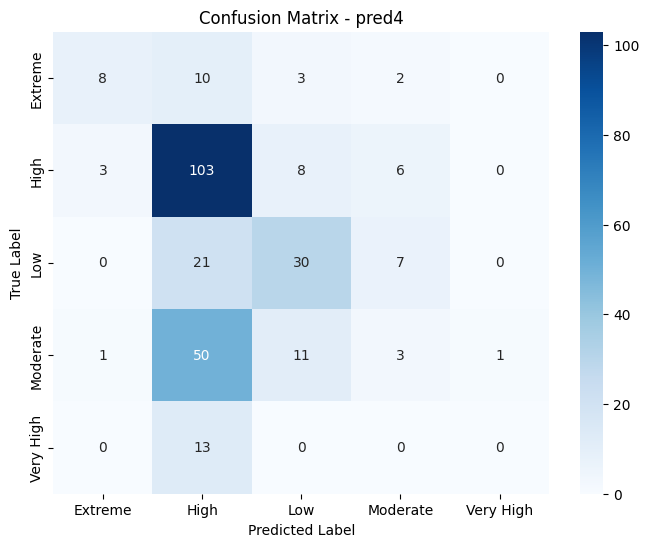

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test4, y_pred4)
classes = np.unique(y_test4)  # Get class labels

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - pred4')
plt.show()

**Skewed Data** is an issue here. The below code block shows that the majority of samples are classified as 'High'. There are very few scores in 'Very High,' possibly because of the uneven stratification of Risk Classes (which I discussed in risk_data_analysis.ipynb...basically there are very different ranges of scores for each class, and I don't have an explanation for why. Very High has a small range of scores that can classify it as very high. That might explain why there are so few observations in that class.)

- 20 <= 'Low' <= 240 (range=220)
- 241 <= 'Moderate' <= 305 (range=64)
- 306 <= 'High' <= 435 (range=129)
- 436 <= 'Very High' <= 505 (range=69)
- 506 <= 'Extreme' <= 1000 (range=494)

In [141]:
print(df['Risk_Rating'].value_counts())

Risk_Rating
High         612
Moderate     313
Low          304
Extreme      117
Very High     54
Name: count, dtype: int64


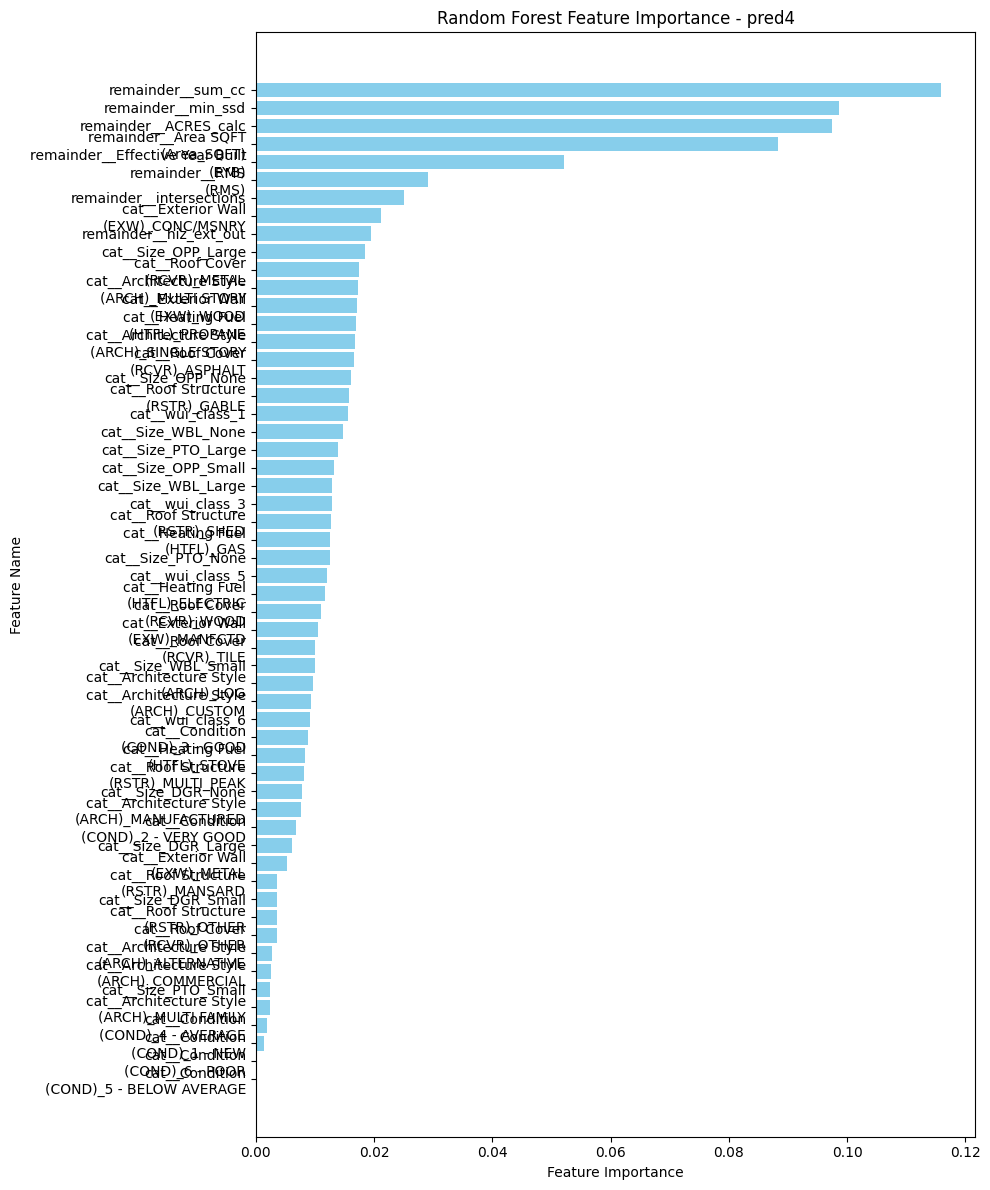

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from training data
feature_importances = pd.DataFrame({
    'Feature': X_train4_enc.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, min(12, 0.5 * len(feature_importances))))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Feature Importance - pred4')
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest at top
plt.show()

In this model, I'm happy to see that some of my variables have the highest importance. sum_cc is the highest, followed by min_ssd, then ACRES_calc, and Area_SQFT. **pred4 is worth pursuing with tweaking hyperparameters of the rf model, and playing with removing noisy variables.**

In [146]:
# Separate num_cols and cat_cols
cat_cols = X_train5.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train5.select_dtypes(exclude=['object']).columns.tolist()

if 'wui_class' in num_cols:
    num_cols.remove('wui_class')
    cat_cols.append('wui_class')


print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['PARCELNB', 'ACCOUNT', 'Air Conditioning\n(AIRC)', 'Architecture Style\n(ARCH)', 'Condition\n(COND)', 'Size_DGR', 'Exterior Wall\n(EXW)', 'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)', 'Interior Wall\n(INT)', 'Size_OPP', 'Size_PTO', 'Roof Cover\n(RCVR)', 'Roof Structure\n(RSTR)', 'Type', 'Size_WBL', 'wui_class']
Numeric columns: ['min_ssd', 'mean_cc0_2m', 'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m', 'intersections', 'ACRES_calc', 'hiz_ext_out', 'Area SQFT\n(Area_SQFT)', 'Effective Year Built\n(EYB)', 'Exterior Percent\n(EXW_PERCENT)', 'RMS\n(RMS)', 'sum_cc']


In [148]:
# One-Hot encoding
encoder = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)],
    remainder="passthrough"  # Keeps numeric columns unchanged
)

# Apply encoding
X_train5_enc = encoder.fit_transform(X_train5)
X_test5_enc = encoder.transform(X_test5)

# Convert back to DataFrame
import pandas as pd
X_train5_enc = pd.DataFrame(X_train5_enc, columns=encoder.get_feature_names_out())
X_test5_enc = pd.DataFrame(X_test5_enc, columns=encoder.get_feature_names_out())

print("Encoded X_train5 shape:", X_train5_enc.shape)
print("Encoded X_test5 shape:", X_test5_enc.shape)

Encoded X_train5 shape: (1120, 2140)
Encoded X_test5 shape: (280, 2140)


In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train5_enc, y_train5) # Using one-hot encoded variables

# Make predictions
y_pred5 = clf.predict(X_test5_enc)

# Accuracy Score
accuracy = accuracy_score(y_test5, y_pred5)
print(f"Accuracy: {accuracy:.3f}")

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test5, y_pred5))

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test5, y_pred5, digits=3))

Accuracy: 0.543
Confusion Matrix:
 [[  6  14   1   2   0]
 [  1 114   4   1   0]
 [  0  24  30   4   0]
 [  0  56   8   2   0]
 [  0  13   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

     Extreme      0.857     0.261     0.400        23
        High      0.516     0.950     0.669       120
         Low      0.698     0.517     0.594        58
    Moderate      0.222     0.030     0.053        66
   Very High      0.000     0.000     0.000        13

    accuracy                          0.543       280
   macro avg      0.459     0.352     0.343       280
weighted avg      0.488     0.543     0.455       280



d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Step 4: Transforming Ground Truth Data 
---
One potential issue with the risk scores is that homes that are not observed receive the highest possible score. Therefore, there is poor agreement between remote observations and in-person observations for specific features such as roof type and distance to nearest home.

To improve model accuracy (we will stick with pred4 for now), we will therefore drop homes that have "Unknown - not observed" scores for every RWRA feature.

One other potential issue with the predictions is that the risk classes are not equal intervals. Therefore, we will create 5 equal-interval risk classes and re-class according to the current scores. Here are the equal-interval classes that we will create and assign to corresponding scores:

**Low: 0 - 200  
Moderate: 201 - 400  
High: 401 - 600  
Very High: 601 - 800  
Extreme: 800 - 1000**

In [151]:
gdf.columns

Index(['rwra_index', 'feat_index', 'parcel_num', 'Year', 'address',
       'ParcelNum', 'Model', 'Address_Visible', 'Driveway_Clearance',
       'Driveway_Lenth', 'Dist_to_Danger_Topo', 'Slope_Final',
       'Background_Fuels', 'Defensible_Space', 'Roofing_Material',
       'Building_Exterior', 'Other_Combustibles', 'Decks_and_Fencing',
       'Proximity_to_Neighboring_Home', 'Ingress_Egress', 'Score_Final',
       'Risk_Rating', 'County', 'wui_class', 'min_ssd', 'mean_cc0_2m',
       'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m', 'intersections',
       'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'Actual Year Built\n(AYB)', 'Air Conditioning\n(AIRC)',
       'Architecture Style\n(ARCH)', 'Area Acres\n(Area_ACRES)',
       'Area SQFT\n(Area_SQFT)', 'Condition\n(COND)',
       'DGR - Detached Garage\n(SubArea_DGR)', 'Effective Year Built\n(EYB)',
       'Exterior Percent\n(EXW_PERCENT)', 'Exterior Wall\n(EXW)',
       'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)'

In [20]:
# Define a function to reassign Risk_Rating
def reassign_risk(score):
    if 0 <= score <= 200:
        return 'Low'
    elif 201 <= score <= 400:
        return 'Moderate'
    elif 401 <= score <= 600:
        return 'High'
    elif 601 <= score <= 800:
        return 'Very High'
    elif 801 <= score <= 10000:
        return 'Extreme'
    else:
        return 'Unknown'  # Catch anything unexpected

# Apply function to create new column
df['Risk_Rating_new'] = df['Score_Final'].apply(reassign_risk)

df.columns

Index(['rwra_index', 'feat_index', 'parcel_num', 'Year', 'address',
       'ParcelNum', 'Model', 'Address_Visible', 'Driveway_Clearance',
       'Driveway_Lenth', 'Dist_to_Danger_Topo', 'Slope_Final',
       'Background_Fuels', 'Defensible_Space', 'Roofing_Material',
       'Building_Exterior', 'Other_Combustibles', 'Decks_and_Fencing',
       'Proximity_to_Neighboring_Home', 'Ingress_Egress', 'Score_Final',
       'Risk_Rating', 'County', 'wui_class', 'min_ssd', 'mean_cc0_2m',
       'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m', 'intersections',
       'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'Air Conditioning\n(AIRC)', 'tax_ARCH', 'tax_SQFT', 'tax_COND',
       'tax_EYB', 'Exterior Percent\n(EXW_PERCENT)', 'tax_EXW', 'Floor\n(FLR)',
       'Frame\n(FRME)', 'tax_HTFL', 'Interior Wall\n(INT)', 'tax_RMS',
       'tax_RCVR', 'tax_RSTR', 'Type', 'sum_cc', 'tax_WBL', 'tax_DGR',
       'tax_PTO', 'tax_OPP', 'Risk_Rating_new'],
      dtype='object')

In [60]:
# Save to temporary file
df.to_csv(os.path.join(scratch, 'MAIN_20250303.csv'), index=False)

In [22]:
# Create new gdf
import geopandas as gpd
gdf = gpd.read_file(os.path.join(out, 'feat_risk_refact.gpkg'), layer='risk_reclass')

gdf2 = df.merge(gdf[['geometry']], left_index=True, right_index=True, how='left')
print(gdf2.shape)
gdf2.head()

(1400, 56)


,rwra_index,feat_index,parcel_num,Year,address,ParcelNum,Model,Address_Visible,Driveway_Clearance,Driveway_Lenth,Dist_to_Danger_Topo,Slope_Final,Background_Fuels,Defensible_Space,Roofing_Material,Building_Exterior,Other_Combustibles,Decks_and_Fencing,Proximity_to_Neighboring_Home,Ingress_Egress,Score_Final,Risk_Rating,County,wui_class,min_ssd,mean_cc0_2m,mean_cc2_4m,mean_cc4_8m,mean_cc8_40m,intersections,PARCELNB,ACCOUNT,ACRES_calc,hiz_ext_out,Air Conditioning\n(AIRC),tax_ARCH,tax_SQFT,tax_COND,tax_EYB,Exterior Percent\n(EXW_PERCENT),tax_EXW,Floor\n(FLR),Frame\n(FRME),tax_HTFL,Interior Wall\n(INT),tax_RMS,tax_RCVR,tax_RSTR,Type,sum_cc,tax_WBL,tax_DGR,tax_PTO,tax_OPP,Risk_Rating_new,geometry
0,0,2836,430506210001,2013.0,123 EXAMPLE DRIVE,430506210001,A,0,5,NaN,0,NaN,75,75,0,0,10,50,NaN,10,225.0,High,Ouray County,1,31.525324,0.028983,0.080487,0.112609,0.179108,1,430506210001,R003918,49.6527,True,1 - NONE,COMMERCIAL,6991.1,3 - GOOD,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,0.776148,METAL,GABLE,Commercial,0.401187,None,None,None,Large,Moderate,POINT (255148.616 4230223.23)
1,1,1110,430506210001,2013.0,129 EXAMPLE DRIVE,430506210001,A,0,5,NaN,0,NaN,50,50,0,20,10,0,NaN,0,135.0,Low,Ouray County,1,31.525324,0.051442,0.096132,0.093393,0.155315,1,430506210001,R003918,49.6527,False,1 - NONE,COMMERCIAL,6991.1,3 - GOOD,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,0.776148,METAL,GABLE,Commercial,0.396283,None,None,None,Large,Low,POINT (255108.006 4230179.848)
2,2,3672,430506210001,2013.0,135 EXAMPLE DRIVE,430506210001,A,0,5,NaN,75,NaN,50,100,0,60,10,50,NaN,10,360.0,Extreme,Ouray County,1,66.164004,0.035089,0.059277,0.031211,0.026098,0,430506210001,R003918,49.6527,True,1 - NONE,COMMERCIAL,6991.1,3 - GOOD,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,0.776148,METAL,GABLE,Commercial,0.151675,None,None,None,Large,Moderate,POINT (255042.316 4230227.366)
3,3,3843,430506210001,2013.0,141 EXAMPLE DRIVE,430506210001,A,0,0,NaN,0,NaN,50,75,200,60,30,0,NaN,0,415.0,Extreme,Ouray County,1,78.033957,0.054498,0.065344,0.076959,0.213781,0,430506210001,R003918,49.6527,False,1 - NONE,COMMERCIAL,6991.1,3 - GOOD,2015.0,10.0,CONC/MSNRY,CONC/MSNRY,WOOD,PROPANE,DRYWALL,0.776148,METAL,GABLE,Commercial,0.410582,None,None,None,Large,High,POINT (255079.817 4230091.78)
4,5,921,403935100181,2017.0,416 COUNTY ROAD 22A,403935100181,B,5,0,11.0,0,0.0,10,50,0,0,0,0,0.0,0,76.0,Low,Ouray County,1,211.505051,0.048738,0.084885,0.034318,0.000000,0,403935100181,R000531,32.7283,False,1 - NONE,SINGLE STORY,4034.9,3 - GOOD,2015.0,100.0,CONC/MSNRY,WDJST,WOOD,GAS,DRYWALL,0.776148,ASPHALT,GABLE,Residence,0.167940,None,None,Large,Large,Low,POINT (252995.437 4241729.295)


In [23]:
# Save as geodataframe object and assign crs
gdf2 = gpd.GeoDataFrame(gdf2, geometry='geometry')
gdf2.set_crs(26913, inplace=True)

# Save gdf2 to gpkg layer
gdf2.to_file(os.path.join(out, 'feat_risk_refact.gpkg'), layer='risk_reclass', driver='GPKG', index=False)

Okay, now that we've reclassified our risk ratings and saved the necessary files, we're going to restart our kernel, set up a new environment, and have a clean slate. We will re-import the data, then we'll use pred4 (we'll rename this) with the random forest classifier again and see if it improves. Then we will drop unknown observations and observations where model=='A' and try the classifier again to see if there is noticeable improvement. 

In [1]:
# setup environment
import os
### Directory ###
# Repository
os.chdir(r'D:/_PROJECTS/P001_OurayParcel/ouray')
# Root workspace
ws = r'D:/_PROJECTS/P001_OurayParcel'

### Data paths ###
# Folder where all the data inputs and outputs will live
data = os.path.join(ws, 'data')
# Scratch folder for intermediate files
scratch = os.path.join(data, '_temp')
# Any final outputs go here
out = os.path.join(data, '_out')
# Figures to export
figs = os.path.join(out, 'figures')

# correct working directory
os.getcwd()

'D:\\_PROJECTS\\P001_OurayParcel\\ouray'

In [31]:
df.columns

Index(['rwra_index', 'feat_index', 'parcel_num', 'Year', 'address',
       'ParcelNum', 'Model', 'Address_Visible', 'Driveway_Clearance',
       'Driveway_Lenth', 'Dist_to_Danger_Topo', 'Slope_Final',
       'Background_Fuels', 'Defensible_Space', 'Roofing_Material',
       'Building_Exterior', 'Other_Combustibles', 'Decks_and_Fencing',
       'Proximity_to_Neighboring_Home', 'Ingress_Egress', 'Score_Final',
       'Risk_Rating', 'County', 'wui_class', 'min_ssd', 'mean_cc0_2m',
       'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m', 'intersections',
       'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'Air Conditioning\n(AIRC)', 'tax_ARCH', 'tax_SQFT', 'tax_COND',
       'tax_EYB', 'Exterior Percent\n(EXW_PERCENT)', 'tax_EXW', 'Floor\n(FLR)',
       'Frame\n(FRME)', 'tax_HTFL', 'Interior Wall\n(INT)', 'tax_RMS',
       'tax_RCVR', 'tax_RSTR', 'Type', 'sum_cc', 'tax_WBL', 'tax_DGR',
       'tax_PTO', 'tax_OPP', 'Risk_Rating_new'],
      dtype='object')

In [32]:
import pandas as pd
# Read in dataframe
df = pd.read_csv(os.path.join(scratch, 'MAIN_20250303.csv'))
# Rename lengthy column names (there is a data dictionary for this for clarity)
df.rename(columns={
    'Area SQFT\n(Area_SQFT)': 'tax_SQFT',
    'Effective Year Built\n(EYB)': 'tax_EYB',
    'RMS\n(RMS)': 'tax_RMS',
    'Architecture Style\n(ARCH)': 'tax_ARCH',
    'Condition\n(COND)': 'tax_COND',
    'Exterior Wall\n(EXW)': 'tax_EXW',
    'Heating Fuel\n(HTFL)': 'tax_HTFL',
    'Roof Cover\n(RCVR)': 'tax_RCVR',
    'Roof Structure\n(RSTR)': 'tax_RSTR',
    'Size_OPP': 'tax_OPP',
    'Size_DGR': 'tax_DGR',
    'Size_WBL': 'tax_WBL',
    'Size_PTO': 'tax_PTO',
    'Air Conditioning\n(AIRC)': 'tax_AIRC',
    'Exterior Percent\n(EXW_PERCENT)': 'tax_EXW_PERCENT',
    'Floor\n(FLR)': 'tax_FLR',
    'Frame\n(FRME)': 'tax_FRME',
    'Interior Wall\n(INT)': 'tax_INT'
}, inplace=True)

# There are NaN values that we want to change to string values that say 'None'
cols2fix = ['tax_OPP', 'tax_DGR', 'tax_WBL', 'tax_PTO']
df[cols2fix] = df[cols2fix].fillna('None')

# Create highest-performing prediction subset (changing 'Risk_Rating' to 'Risk_Rating_new' for target feature)
pred = df[
    [
    'Risk_Rating_new',
    'wui_class',
    'hiz_ext_out',
    'min_ssd', 
    'intersections', 
    'sum_cc', 
    'ACRES_calc', 
    'tax_SQFT',
    'tax_EYB',
    'tax_RMS',
    'tax_ARCH',
    'tax_COND',
    'tax_EXW',
    'tax_HTFL',
    'tax_RCVR', 
    'tax_RSTR',
    'tax_OPP',
    'tax_DGR',
    'tax_WBL',
    'tax_PTO'
    ]
]



In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rwra_index                     1400 non-null   int64  
 1   feat_index                     1400 non-null   int64  
 2   parcel_num                     1400 non-null   int64  
 3   Year                           1400 non-null   float64
 4   address                        593 non-null    object 
 5   ParcelNum                      1400 non-null   int64  
 6   Model                          1400 non-null   object 
 7   Address_Visible                1400 non-null   int64  
 8   Driveway_Clearance             1400 non-null   int64  
 9   Driveway_Lenth                 1396 non-null   float64
 10  Dist_to_Danger_Topo            1400 non-null   int64  
 11  Slope_Final                    1396 non-null   float64
 12  Background_Fuels               1400 non-null   i

In [35]:
# Train-test split
from sklearn.model_selection import train_test_split
# Define train-test split function
def split_data(df):
    X = df.drop(columns=['Risk_Rating_new'])
    y = df['Risk_Rating_new']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Apply to prediction subset
X_train, X_test, y_train, y_test = split_data(pred)

In [36]:
X_train.head()

,wui_class,hiz_ext_out,min_ssd,intersections,sum_cc,ACRES_calc,tax_SQFT,tax_EYB,tax_RMS,tax_ARCH,tax_COND,tax_EXW,tax_HTFL,tax_RCVR,tax_RSTR,tax_OPP,tax_DGR,tax_WBL,tax_PTO
1121,1,True,38.012572,0,0.538100,1.21926,2292.0,2000.0,9.000000,SINGLE STORY,3 - GOOD,WOOD,ELECTRIC,METAL,GABLE,Large,None,None,None
48,5,False,211.157384,0,0.114779,38.81210,1104.0,2005.0,0.776148,SINGLE STORY,3 - GOOD,MANFCTD,PROPANE,METAL,SHED,None,None,None,None
155,1,False,208.433977,0,0.394297,13.10870,1188.0,2010.0,0.776148,MANUFACTURED,3 - GOOD,CONC/MSNRY,PROPANE,ASPHALT,SHED,None,None,None,None
306,1,True,225.044477,0,0.572324,4.56229,2235.3,2010.0,0.776148,MULTI STORY,3 - GOOD,CONC/MSNRY,GAS,OTHER,OTHER,Large,None,Large,None
1287,3,False,5.050919,2,0.099414,38.25570,1204.0,1990.0,0.000000,SINGLE STORY,3 - GOOD,WOOD,PROPANE,ASPHALT,GABLE,Large,Small,None,None


In [34]:
# Save df checkpoint
df.to_csv(os.path.join(scratch, 'MAIN_20250303.csv'), index=False)

In [37]:
# Separate num_cols and cat_cols
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

if 'wui_class' in num_cols:
    num_cols.remove('wui_class')
    cat_cols.append('wui_class')

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['tax_ARCH', 'tax_COND', 'tax_EXW', 'tax_HTFL', 'tax_RCVR', 'tax_RSTR', 'tax_OPP', 'tax_DGR', 'tax_WBL', 'tax_PTO', 'wui_class']
Numeric columns: ['hiz_ext_out', 'min_ssd', 'intersections', 'sum_cc', 'ACRES_calc', 'tax_SQFT', 'tax_EYB', 'tax_RMS']


In [38]:
# One-Hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)],
    remainder="passthrough"  # Keeps numeric columns unchanged
)

# Apply encoding
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

# Convert back to DataFrame
import pandas as pd
X_train_enc = pd.DataFrame(X_train_enc, columns=encoder.get_feature_names_out())
X_test_enc = pd.DataFrame(X_test_enc, columns=encoder.get_feature_names_out())

print("Encoded X_train shape:", X_train_enc.shape)
print("Encoded X_test shape:", X_test_enc.shape)

Encoded X_train shape: (1120, 56)
Encoded X_test shape: (280, 56)


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train_enc, y_train) # Using one-hot encoded variables

# Make predictions
y_pred = clf.predict(X_test_enc)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

Accuracy: 0.632
Confusion Matrix:
 [[  5   0   0   6   0]
 [  1   1   0  45   0]
 [  0   0   5  36   0]
 [  3   3   2 166   0]
 [  0   1   0   6   0]]
Classification Report:
               precision    recall  f1-score   support

     Extreme      0.556     0.455     0.500        11
        High      0.200     0.021     0.038        47
         Low      0.714     0.122     0.208        41
    Moderate      0.641     0.954     0.767       174
   Very High      0.000     0.000     0.000         7

    accuracy                          0.632       280
   macro avg      0.422     0.310     0.303       280
weighted avg      0.558     0.632     0.533       280



d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\python\parcel\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


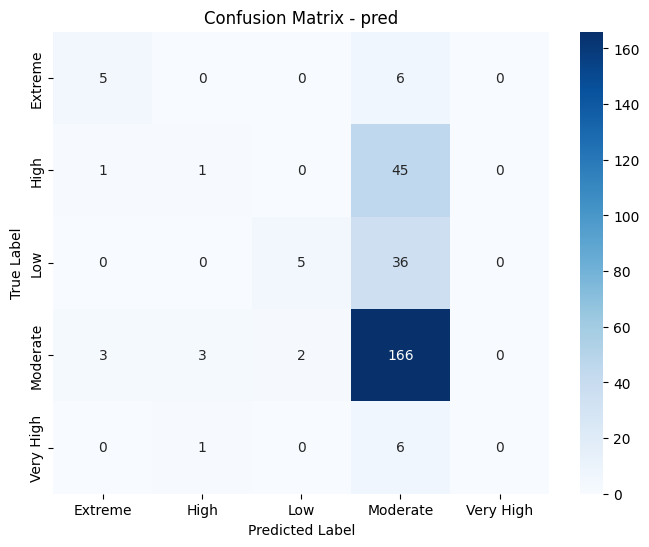

In [40]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)  # Get class labels

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - pred')
plt.show()

We can see that the overwhelming majority of risk scores now fall in the "Moderate"  class. RF model accuracy has improved, but most predictions are "Moderate" because that's what the model was primarily trained on.

There are 13 RWRA feature columns. I would like to know how many observations are in this dataset where at least 8 of these column values end in a 1. This would denote that the structure was largely unobserved.

In [49]:
# Define the rwra columns
rwra_cols = [
    'Address_Visible', 'Driveway_Clearance', 'Driveway_Lenth', 'Dist_to_Danger_Topo', 
    'Slope_Final', 'Background_Fuels', 'Defensible_Space', 'Roofing_Material', 
    'Building_Exterior', 'Other_Combustibles', 'Decks_and_Fencing', 
    'Proximity_to_Neighboring_Home', 'Ingress_Egress'
]

# Function to check if a value ends in "1"
def ends_in_1(value):
    if pd.notna(value):  # Ignore NaN values
        return str(int(value)).endswith('1')  # Convert to string & check last character
    return False

# Apply function to rwra_cols and count how many "1-ending" values per row
count_1s_per_row = df[rwra_cols].applymap(ends_in_1).sum(axis=1)

# Count observations where at least 8 columns end in "1"
num_obs = (count_1s_per_row >= 6).sum()

# Print the result
print(f"Number of observations with at least 8 rwra_cols ending in '1': {num_obs}")


Number of observations with at least 8 rwra_cols ending in '1': 85


C:\Users\User\AppData\Local\Temp\ipykernel_35012\4163802035.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  count_1s_per_row = df[rwra_cols].applymap(ends_in_1).sum(axis=1)


There are 68 observations where at least 8 features were unobserved and 85 observations where at least 6 features were unobserved.

In [57]:
# Function to check if a value ends in "1"
def ends_in_1(value):
    if pd.notna(value):  # Ignore NaN values
        return str(int(value)).endswith('1')  # Convert to string & check last character
    return False

# Apply function to rwra_cols and count how many "1-ending" values per row
count_1s_per_row = df[rwra_cols].applymap(ends_in_1).sum(axis=1)

# Apply the condition: At least 8 unobserved (ends in '1') AND 'Risk_Rating_new' == 'Extreme'
num_obs = ((count_1s_per_row >= 6) & (df['Risk_Rating_new'] == 'Extreme')).sum()

# Print the result
print(f"Number of observations where at least 8 features are unobserved (ends in '1') AND Risk_Rating == 'Extreme': {num_obs}")

Number of observations where at least 8 features are unobserved (ends in '1') AND Risk_Rating == 'Extreme': 62


C:\Users\User\AppData\Local\Temp\ipykernel_35012\311438386.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  count_1s_per_row = df[rwra_cols].applymap(ends_in_1).sum(axis=1)


In [55]:
print(df['Risk_Rating_new'].value_counts())

Risk_Rating_new
Moderate     943
High         182
Low          177
Extreme       63
Very High     35
Name: count, dtype: int64


**Original Classification of Extreme Risk and Unobserved Features**  
- 68 of 68 observations with at least 8 unobserved features have a 'Risk_Rating' (original classification) of 'Extreme'. That is 68 of 117 total 'Extreme' observations.  
- 81 of 85 observations where at least 6 features were unobserved have a 'Risk_Rating' (original classification) of 'Extreme'. That is 81 of 117 total 'Extreme' observations.  

**Reclassified Extreme Risk and Unobserved Features**  
- 60 of 63 'Extreme' values of 'Risk_Rating_new' (reclassified) have at least 8 unobserved features
- 62 of 63 'Extreme' values of 'Risk_Rating_new' (reclassified) have at least 6 unobserved features


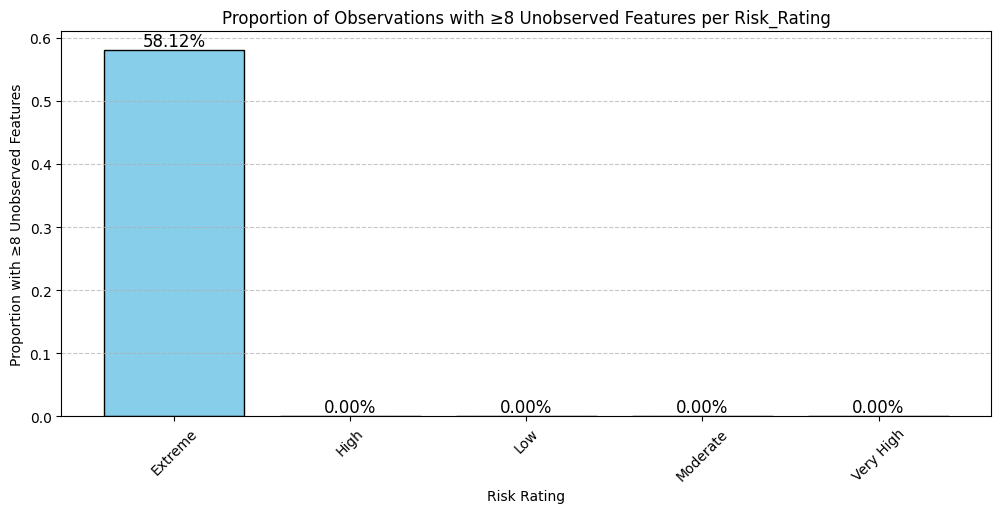

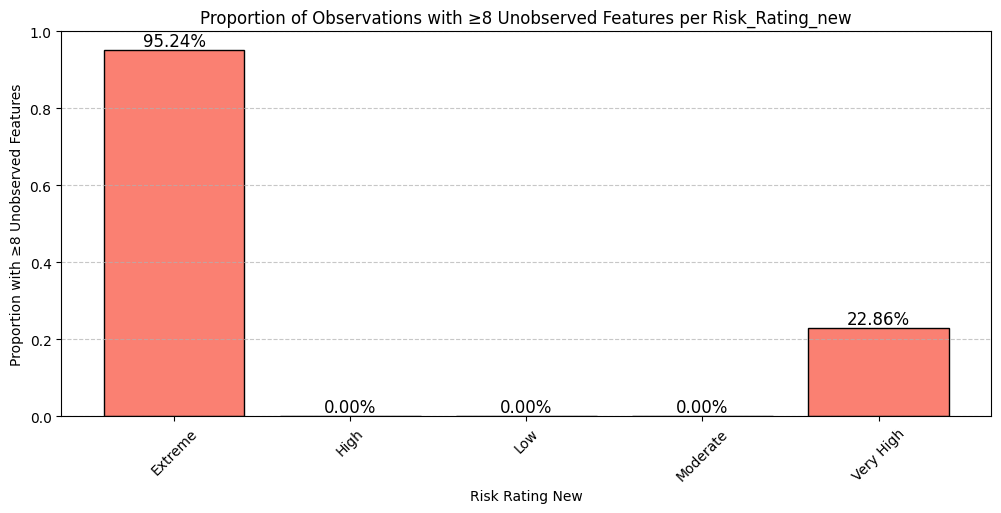

In [59]:
# Create a new column to flag observations with at least 8 unobserved features
df['At_Least_8_Unobserved'] = count_1s_per_row >= 8

# Calculate proportions for 'Risk_Rating'
risk_rating_counts = df.groupby('Risk_Rating')['At_Least_8_Unobserved'].mean()

# Calculate proportions for 'Risk_Rating_new'
risk_rating_new_counts = df.groupby('Risk_Rating_new')['At_Least_8_Unobserved'].mean()

# Plot histogram for 'Risk_Rating'
plt.figure(figsize=(12, 5))

bars = plt.bar(risk_rating_counts.index, risk_rating_counts.values, color='skyblue', edgecolor='black')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2%}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Risk Rating')
plt.ylabel('Proportion with ≥8 Unobserved Features')
plt.title('Proportion of Observations with ≥8 Unobserved Features per Risk_Rating')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot histogram for 'Risk_Rating_new'
plt.figure(figsize=(12, 5))
bars = plt.bar(risk_rating_new_counts.index, risk_rating_new_counts.values, color='salmon', edgecolor='black')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2%}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Risk Rating New')
plt.ylabel('Proportion with ≥8 Unobserved Features')
plt.title('Proportion of Observations with ≥8 Unobserved Features per Risk_Rating_new')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see in the above histograms that in 'Risk_Rating' (original classification), 58.12% of all homes that received a 'Risk_Rating' of 'Extreme' had at least 8 of 13 RWRA features that were unobserved. All homes with at least 8 unobserved features received an 'Extreme' value of 'Risk_Rating'. 

95.24% of all 'Extreme' values of 'Risk_Rating_new' (reclassified with equal interval buckets) had at least 8 unobserved features. The only homes with at least 8 unobserved features received 'Very High' or 'Extreme' classifications in 'Risk_Rating_new'. 

## Conclusions (brief)
---
RWRA scores are difficult to predict. The model that performed the best was the random forest predicting on equal-interval risk ratings, with an accuracy of about 63.2%. This accuracy varied across prediction classes. 

**Classification Report**

| Class       | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Extreme    | 0.556     | 0.455  | 0.500    | 11      |
| High       | 0.200     | 0.021  | 0.038    | 47      |
| Low        | 0.714     | 0.122  | 0.208    | 41      |
| Moderate   | 0.641     | 0.954  | 0.767    | 174     |
| Very High  | 0.000     | 0.000  | 0.000    | 7       |

**Overall Metrics**
| Metric        | Value  |
|--------------|--------|
| Accuracy     | 0.632  |
| Macro Avg    | 0.422  | 
| Recall Avg   | 0.310  |
| F1-Score Avg | 0.303  |
| Weighted Avg | 0.558  |


This model predicted almost exlusively 'Moderate' ratings, so its value is inconclusive on this dataset. The largest predictor of RWRA scores is whether the features of a structure and its defensible space can be easily observed from the road or not. This finding is supported by Meldrum et al. 2022. The most important feature from remote assessments was GIS acres. This finding is rather unsatisfying. Remote assessments may provide a more nuanced and objective risk assessment with a greater amount of homes that can be assessed in a much shorter time frame.  

This concludes `risk_pred.ipynb`. The next notebook in the workflow is `clustering.ipynb`. In that notebook, I will attempt to classify homes according to my remote risk assessments. 